# Cognitive Reinforcement Learning

In this tutorial, you'll simulate cognitive models of human behavior in **instrumental learning tasks** — situations where people learn through trial and error which actions lead to rewarding outcomes.

We’ll draw on core ideas from **reinforcement learning (RL)**, but focus on how to use these concepts to understand how **humans actually behave**, as observed in empirical experiments. Traditional RL often assumes agents behave optimally, but cognitive models aim to capture the **heuristics, limitations, and biases** that shape real-world human decision-making.

In a typical instrumental learning task, participants repeatedly choose between two abstract stimuli. Each choice produces **probabilistic feedback**, and the participant must learn which option is more rewarding in the long run.

Throughout the tutorial, you'll simulate behavior under different models and explore how various learning and decision strategies produce different patterns of choice.

---

### What You’ll Learn

#### Simulation: Do different models lead to different behaviors?

* Compare different **choice strategies**: greedy, ε-greedy, and softmax
* Explore how different **learning rules** shape value updates

#### Fitting: From behavior to parameters

* Compute **log-likelihoods** of observed choices
* Use **optimization** to fit model parameters to data
* Evaluate **parameter recovery** to test model validity
* Formally **compare** computational models

---
Cognitive Modelling course 2025-2026
SM

#### Code Setup

Before we dive into the simulations, let's set up our coding environment. We'll use the following libraries:

* `numpy`: For numerical operations and handling arrays.
* `pandas`: For data manipulation and storage.
* `scipy`: For optimization and statistical functions.
* `matplotlib`: For plotting and visualizing data.

In [11]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

## Part 1. Simulation: Different models, different behavior(?)
We need to write some code to simulate a single subject's data with softmax and the standard delta rule for learning. The cell below is an implementation of the softmax function:

In [12]:
def softmax(Q, inverse_temperature):
    """
    Computes the softmax probabilities for a given set of Q-values.

    Parameters:
        Q (ndarray): Q-values for each choice option
        inverse_temperature (float): beta parameter for softmax choice

    Returns:
        ndarray: Softmax probabilities for each choice option
    """
    z = Q*inverse_temperature
    return np.exp(z) / np.sum(np.exp(z))

The function `simulate_softmax()` below is aimed to simulate a single subject's behavior. However, it is incomplete.

#### Assignment 1.1 
Fill in the `TODOs` in the `simulate_softmax()` function below to make it work.

In [13]:
def simulate_softmax(n_trials, learning_rate, inverse_temperature, p_reward, initial_Q=0.5):
    """
    Simulates behavior in a 2-choice reinforcement learning task.

    Parameters:
        n_trials (int): number of trials
        learning_rate (float): alpha parameter for updating Q-values
        inverse_temperature (float): beta parameter for softmax choice
        p_reward (list): reward probabilities for each option

    Returns:
        Q (ndarray): Q-values over time
        P (ndarray): Probability of each choice option over time
        behavior (DataFrame): choices and rewards for each trial
    """
    
    n_choice_options = len(p_reward)
    
    # Initialize Q-values, probabilities of choice, and behavior storage
    Q = np.zeros(shape=(n_trials + 1, n_choice_options)) + initial_Q
    P = np.zeros(shape=(n_trials, n_choice_options))
    behavior = pd.DataFrame(index=np.arange(n_trials), columns=['choice', 'reward'])

    for trial_n in range(n_trials):
        Q_trial = Q[trial_n, :]

        # Compute choice probabilities using softmax
        p_choices = softmax(Q_trial, inverse_temperature=inverse_temperature)
        P[trial_n,:] = p_choices

        # Sample a choice based on p_choices
        choice_idx = np.random.choice([0, 1], p=p_choices)

        # Sample a reward based on the chosen option's reward probability
        reward = np.random.binomial(1, p_reward[choice_idx])

        # Record choice and reward
        behavior.loc[trial_n, 'choice'] = choice_idx
        behavior.loc[trial_n, 'reward'] = reward

        # Compute the reward prediction error
        reward_prediction_error = reward - Q_trial[choice_idx]

        # Update Q-value for chosen option
        Q[trial_n + 1, choice_idx] = Q_trial[choice_idx] + learning_rate * reward_prediction_error

        # Carry forward unchosen Q-value
        Q[trial_n + 1, 1 - choice_idx] = Q_trial[1 - choice_idx]

    return Q, P, behavior

##### Testing Your Code
To test if your code is correct, run the plotting code in the cell below. It should generate this figure: 
![Assignment 1](https://surfdrive.surf.nl/files/index.php/s/Iz9SENiUgZhmCbD/download)

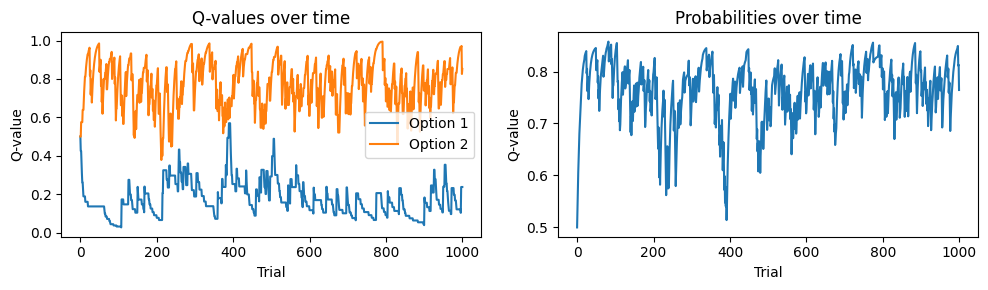

In [14]:
np.random.seed(2)
Q, P, behavior = simulate_softmax(n_trials=1000, learning_rate=0.15, inverse_temperature=2, p_reward=[0.2, 0.8])

# Plot Q-values over time
f, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(np.arange(Q.shape[0]), Q[:, 0], label='Option 1')
ax[0].plot(np.arange(Q.shape[0]), Q[:, 1], label='Option 2')
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('Q-value')
ax[0].legend()
ax[0].set_title('Q-values over time')

# Plot probability of choosing option 2 over time
ax[1].plot(np.arange(P.shape[0]), P[:,1])
ax[1].set_title('Probabilities over time')
ax[1].set_xlabel('Trial')
ax[1].set_ylabel('Q-value')
plt.tight_layout()

#### <p style="color:Red;">Discussion 1.1</p>
The agent chooses between two options and learns from rewards.  
It picks using softmax and updates Q-values after each trial to find which option is better.


#### Assignment 1.2
Let's explore the effects of the model parameters.

##### Assignment 1.2.1
What is the proportion of optimal choices in the simulated `behavior`? Write a function `p_optimal()` that takes the `behavior` and returns the proportion optimal choices. Complete the code skeleton below.

In [15]:
def p_optimal(behavior):
    choices = behavior['choice'].astype(int)
    optimal_choices = np.sum(choices == 1) # Count chosen option 2 (index 1)
    proportion = optimal_choices / len(choices)
    return proportion

##### Assignment 1.2.2 
How does the proportion of optimal choices depend on the softmax inverse temperature parameter? 

To find out, complete the cell below to do the following:
1. Simulate 51 datasets with inverse temperature values of 0 to 10 with increments of 0.2. Keep the learning rate fixed to 0.15.
2. For each simulated dataset, calculate the proportion optimal choices with `p_optimal()`. 
3. Plot p_optimal as a function of inverse_temperature.

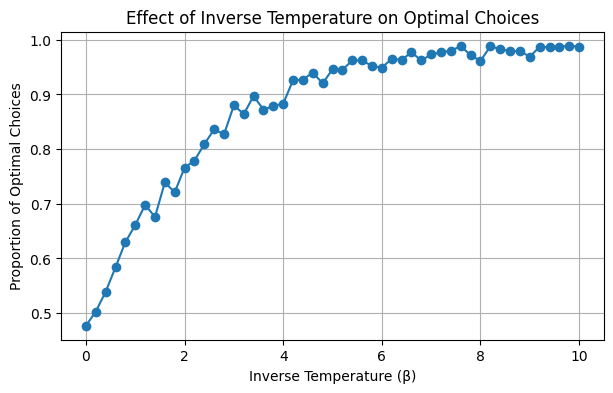

In [16]:
inverse_temperatures = np.arange(0, 10.2, 0.2)
prop_optimal = np.zeros_like(inverse_temperatures)

# simulate per inverse temperature
for i, inverse_temperature in enumerate(inverse_temperatures):
    Q, P, behavior = simulate_softmax(
        n_trials=1000,
        learning_rate=0.15,
        inverse_temperature=inverse_temperature,
        p_reward=[0.2, 0.8]
    )
    prop_optimal[i] = p_optimal(behavior) # proportion of optimals

plt.figure(figsize=(7,4))
plt.plot(inverse_temperatures, prop_optimal, marker='o')
plt.xlabel("Inverse Temperature (β)")
plt.ylabel("Proportion of Optimal Choices")
plt.title("Effect of Inverse Temperature on Optimal Choices")
plt.grid(True)
plt.show()

#### <p style="color:Red;">Discussion 1.2.2</p>
When β is small, the agent picks randomly, so it often chooses the wrong option.  
When β gets bigger, it chooses the better option more often.  
So, higher β makes the agent more sure and better at picking the best choice.


##### Assignment 1.2.3 
How does the learning rate parameter influence the Q values (and subsequently, data)?

To find out, complete the cell below to do the following:
1. Simulate three datasets: One with a learning rate of 0.02, one with 0.15, and one with 0.5 Keep the inverse temperature parameter fixed to 2.
2. For each dataset, plot the evolution of Q-values and choice probabilities over time.

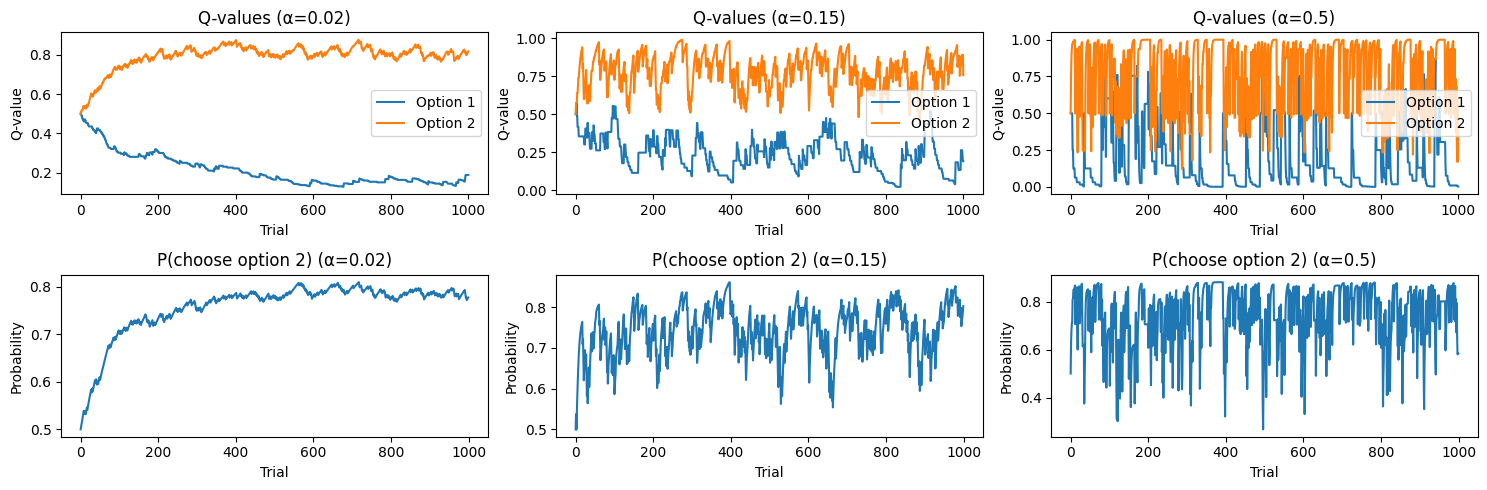

In [17]:
f, ax = plt.subplots(2, 3, figsize=(15, 5))
learning_rates = [0.02, 0.15, 0.5]
for i, alpha in enumerate(learning_rates):
    Q, P, behavior = simulate_softmax(
        n_trials=1000,
        learning_rate=alpha,
        inverse_temperature=2,
        p_reward=[0.2, 0.8]
    )

    ax[0, i].plot(Q[:, 0], label='Option 1')
    ax[0, i].plot(Q[:, 1], label='Option 2')
    ax[0, i].set_title(f'Q-values (α={alpha})')
    ax[0, i].set_xlabel('Trial')
    ax[0, i].set_ylabel('Q-value')
    ax[0, i].legend()

    ax[1, i].plot(P[:, 1])
    ax[1, i].set_title(f'P(choose option 2) (α={alpha})')
    ax[1, i].set_xlabel('Trial')
    ax[1, i].set_ylabel('Probability')

plt.tight_layout()
plt.show()

#### <p style="color:Red;">Discussion 1.2.3</p>
The learning rate (α) decides how fast the agent learns from rewards.

Small α → learns very slowly.  
Medium α → learns well and is steady.  
Big α → changes too fast and becomes messy.

So, too small is slow, too big is unstable. A middle value works best.

#### Discussion Questions

##### Proportion of Optimal Choices:
- How does the inverse temperature parameter affect the agent's ability to choose the optimal option?
<p style="color:Red">Answer:</p> 
Higher β makes the agent pick the best option more often.

- Why might higher inverse temperatures lead to more optimal choices?
<p style="color:Red">Answer:</p> 
Big β means choices are less random, so it chooses better.
  
##### Learning Rate:
- How does the learning rate influence the Q-values and choice probabilities
<p style="color:Red">Answer:</p> 
Higher α makes Q-values change faster and more strongly.

- What are the implications of using a high vs. low learning rate in real-world scenarios?
<p style="color:Red">Answer:</p> 
Low α learns slowly; high α reacts too fast and can be unstable.

#### Assignment 1.3. Exploring Choice Rules

So far, you've implemented a reinforcement learning agent that uses a **softmax choice rule** to balance exploration and exploitation.

Your task now is to implement **two alternative choice strategies**:

1. **Greedy**: Always pick the option with the highest estimated value (i.e., max Q).
2. **ε-greedy**: Most of the time, pick the best option (greedy), but with small probability ε, choose randomly.

### Instructions

1. **Use the code skeleton of `simulate_generic()`** below as a starting point.
2. Fill in the `TODO` with an implementation of an **ε-greedy** rule: with probability `epsilon`, pick randomly; otherwise, pick `np.argmax(Q)`
3. Run simulations: Try different values of `epsilon`, e.g., `0.1`, `0.01`, `0.3`.

### Suggested Plots

* Plot the **cumulative sum of optimal choices** across trials.
* Plot the **cumulative sum of rewards** to compare agent performance.

### Discussion Questions

* Which policy earns the most reward in the long run? Why?
* What are the strengths and weaknesses of each strategy?
* How sensitive is ε-greedy to the value of `ε`?

In [18]:
def simulate_generic(n_trials, learning_rate, choice_parameter, p_reward, choice_rule='softmax'):
    """
    Simulates behavior in a 2-choice reinforcement learning task.

    Parameters:
        n_trials (int): number of trials
        learning_rate (float): alpha parameter for updating Q-values
        choice_parameter (float): beta parameter for softmax choice OR epsilon value for (epsilon-)greedy rule
        p_reward (list): reward probabilities for each option
        choice_rule (string): choice rule to use ('softmax', 'epsilon_greedy', or 'greedy')

    Returns:
        Q (ndarray): Q-values over time
        P (ndarray): Probability of each choice option over time
        behavior (DataFrame): choices and rewards for each trial
    """

    # note that greedy is just epsilon_greedy with epsilon = 0.
    # if the user passes both a choice_parameter and greedy, ignore the choice
    # parameter. You should probably throw an error here but for the current purposes
    # this is fine.
    if choice_rule == 'greedy':
        choice_parameter = 0
        choice_rule = 'epsilon_greedy'
    
    n_choice_options = len(p_reward)
    
    # Initialize Q-values and behavior storage
    Q = np.zeros(shape=(n_trials + 1, n_choice_options)) + 0.5
    P = np.zeros(shape=(n_trials, n_choice_options))
    behavior = pd.DataFrame(index=np.arange(n_trials), columns=['choice', 'reward'])

    for trial_n in range(n_trials):
        Q_trial = Q[trial_n, :]

        # Compute choice probabilities
        if choice_rule == 'softmax':
            p_choices = softmax(Q_trial, inverse_temperature=choice_parameter)
        elif choice_rule == 'epsilon_greedy':
            epsilon = choice_parameter
            p_choices = np.array([epsilon/2, epsilon/2])
            best = np.argmax(Q_trial)
            p_choices[best] += (1 - epsilon)

        # the rest of the code is the same as before.
        P[trial_n,:] = p_choices
        
        choice_idx = np.random.choice([0,1], p=p_choices)

        # Sample a reward based on the chosen option's reward probability
        reward = np.random.binomial(n=1, p=p_reward[choice_idx])

        # Record choice and reward
        behavior.loc[trial_n, 'choice'] = choice_idx
        behavior.loc[trial_n, 'reward'] = reward

        # Compute the reward prediction error
        reward_prediction_error = reward_prediction_error = (reward-Q_trial[choice_idx])

        # Update Q-value for chosen option
        Q[trial_n + 1, choice_idx] = Q_trial[choice_idx] + learning_rate * reward_prediction_error

        # Carry forward unchosen Q-value
        Q[trial_n + 1, 1 - choice_idx] = Q_trial[1 - choice_idx]

    return Q, P, behavior

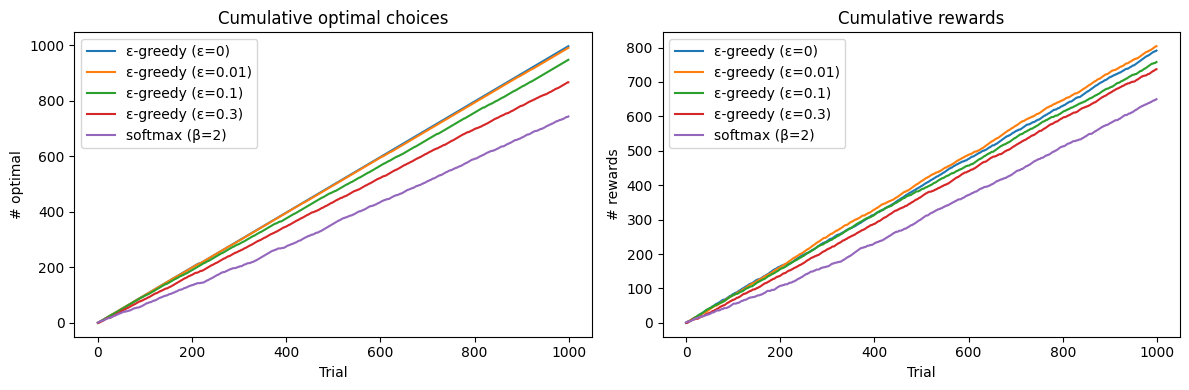

In [19]:
np.random.seed(7)

n_trials = 1000
p_reward = [0.2, 0.8]
optimal_idx = int(np.argmax(p_reward))

runs = []

# epsilon-greedy with different epsilons
for eps in [0, 0.01, 0.1, 0.3]:  # 0 = greedy
    Q, P, beh = simulate_generic(n_trials, 0.15, eps, p_reward, 'epsilon_greedy')
    runs.append((f'ε-greedy (ε={eps})', beh))

# softmax baseline
Q, P, beh = simulate_generic(n_trials, 0.15, 2.0, p_reward, 'softmax')
runs.append((f'softmax (β=2)', beh))

# helper arrays
def cum_optimal(behavior, optimal_idx):
    choices = behavior['choice'].astype(int).values
    return np.cumsum(choices == optimal_idx)

def cum_rewards(behavior):
    rewards = behavior['reward'].astype(int).values
    return np.cumsum(rewards)

# plot
f, ax = plt.subplots(1, 2, figsize=(12, 4))

for label, beh in runs:
    ax[0].plot(cum_optimal(beh, optimal_idx), label=label)
    ax[1].plot(cum_rewards(beh), label=label)

ax[0].set_title('Cumulative optimal choices')
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('# optimal')

ax[1].set_title('Cumulative rewards')
ax[1].set_xlabel('Trial')
ax[1].set_ylabel('# rewards')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()


#### <p style="color:Red;">Discussion  1.3</p>

• Which policy earns most reward?  
Usually **ε-greedy with small ε** or **softmax with higher β** wins, because they still explore a bit.

• Strengths/weaknesses?  
Greedy: simple but can get stuck.  
ε-greedy: safe exploration but can waste some trials.  
Softmax: smooth trade-off, fewer hard jumps.

• Sensitivity to ε?  
Too small → almost greedy; too big → too random; a small ε (like 0.01–0.1) works well.

Think about this result. It looks like it's optimal to be greedy. Is it really? Think about the effects of different contexts

#### Assignment 1.4. Exploring Learning Rules

Now, let's explore different ways of learning. Your task is to implement a delta rule with two separate learning rates:

1. **$\alpha_{pos}$**: Learning rate for better-than-expected rewards (positive reward prediction errors)
2. **$\alpha_{neg}$**: Learning rate for worse-than-expected rewards (negative reward prediction errors)

### Instructions

1. **Copy the simulation code above** as a starting point.
2. Replace the learning rule
3. Try different values of `learning_rate_pos` and `learning_rate_neg`, e.g., `0.2/0.2`, `0.0/0.3`, `0.3/0.0`.
4. Run simulations and plot the **Q-value of the optimal choice option** across trials

### Discussion Questions

* Can you describe how this model differs from the standard delta rule?
* Can you think of psychological interpretations of learning asymmetries? E.g., think about the proverbial carrots & sticks.

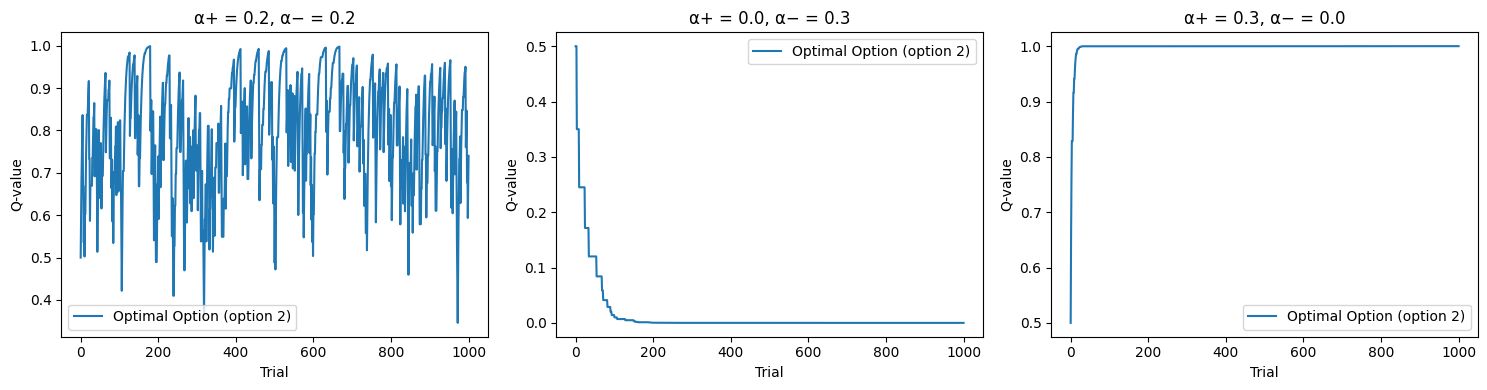

In [20]:
## Your code here. Start by copying the simulate_generic() function, and change the code where necessary.

def simulate_asym_learning(n_trials, learning_rate_pos, learning_rate_neg, choice_parameter, p_reward, choice_rule='softmax'):
    """
    Simulates behavior with separate learning rates for positive and negative feedback.
    """
    if choice_rule == 'greedy':
        choice_parameter = 0
        choice_rule = 'epsilon_greedy'
    
    Q = np.zeros((n_trials + 1, 2)) + 0.5
    behavior = pd.DataFrame(index=np.arange(n_trials), columns=['choice', 'reward'])

    for trial_n in range(n_trials):
        Q_trial = Q[trial_n, :]

        # softmax choice
        if choice_rule == 'softmax':
            p_choices = softmax(Q_trial, inverse_temperature=choice_parameter)
        else:
            epsilon = choice_parameter
            p_choices = np.array([epsilon/2, epsilon/2])
            best = np.argmax(Q_trial)
            p_choices[best] += (1 - epsilon)

        choice = np.random.choice([0, 1], p=p_choices)
        reward = np.random.binomial(1, p_reward[choice])

        behavior.loc[trial_n, 'choice'] = choice
        behavior.loc[trial_n, 'reward'] = reward

        # reward prediction error
        rpe = reward - Q_trial[choice]

        # use different α for positive and negative errors
        if rpe > 0:
            alpha = learning_rate_pos
        else:
            alpha = learning_rate_neg

        Q[trial_n + 1, choice] = Q_trial[choice] + alpha * rpe
        Q[trial_n + 1, 1 - choice] = Q_trial[1 - choice]

    return Q, behavior

f, ax = plt.subplots(1, 3, figsize=(15, 4))
p_reward = [0.2, 0.8]
n_trials = 1000

settings = [
    (0.2, 0.2, 'α+ = 0.2, α− = 0.2'),
    (0.0, 0.3, 'α+ = 0.0, α− = 0.3'),
    (0.3, 0.0, 'α+ = 0.3, α− = 0.0')
]

for i, (a_pos, a_neg, label) in enumerate(settings):
    Q, behavior = simulate_asym_learning(n_trials, a_pos, a_neg, 2, p_reward, 'softmax')
    ax[i].plot(Q[:, 1], label='Optimal Option (option 2)')
    ax[i].set_title(label)
    ax[i].set_xlabel('Trial')
    ax[i].set_ylabel('Q-value')
    ax[i].legend()

plt.tight_layout()
plt.show()


This model learns differently from good and bad outcomes.  
When α+ > α−, it learns fast from rewards (positive feedback).  
When α− > α+, it learns fast from mistakes (negative feedback).  
This shows how people can learn more from either good or bad results — “carrots” vs “sticks.”


## Part 2. Fitting: From data to parameters

Model fitting entails finding the set of parameters that maximize the probability of the data:

$$
P(D | \theta)
$$

where:

* $D$ is the observed data (e.g., choices and rewards),
* $\theta$ represents the model parameters (e.g., learning rate $\alpha$, inverse temperature $\beta$).

Since we often work with log-probabilities for numerical stability and easier optimization, we typically maximize the **log-likelihood**:

$$
\log P(D | \theta) = \sum_{t=1}^T \log P(a_t | Q_t, \theta)
$$

where:

* $a_t$ is the action (choice) made on trial $t$,
* $Q_t$ is the vector of Q-values on trial $t$,
* $P(a_t | Q_t, \theta)$ is the probability of the chosen action given the Q-values and parameters.


Let's re-simulate the same dataset as in the first assignment to ensure reproducability.

In [ ]:
np.random.seed(2)
Q, P, behavior = simulate_softmax(n_trials=1000, learning_rate=0.15, 
                                  inverse_temperature=2, p_reward=[0.2, 0.8])

#### Assignment 2.1
In this assignment, you calculate the log likelihood $\log P(D|\theta)$ of the choices in `behavior` given the set of parameters $\alpha=0.2$ and $\beta=2$. The answer should be `-547.8743757210163`.

To get there, complete the function `ll_softmax()` below that takes as arguments:
- the data `behavior`,
- a learning rate,
- an inverse temperature
 
and **returns** the summed log-likelihood.

In [ ]:
def ll_softmax(behavior, learning_rate, inverse_temperature, initial_q=0.5):
    """
    Computes the log-likelihood of the observed choices given the model parameters.

    Parameters:
        behavior (DataFrame): DataFrame containing choices and rewards
        learning_rate (float): alpha parameter for updating Q-values
        inverse_temperature (float): beta parameter for softmax choice
        initial_q (float): initial Q-value for all options

    Returns:
        float: Summed log-likelihood of the observed choices
    """
    
    # Estimating the likelihood bears resemblance to 
    # simulating the model.
    # We again need to estimate Q-values and the probability of each 
    # choice option
    n_trials = behavior.shape[0]
    Q = np.zeros(shape=(n_trials+1,2))+initial_q
    P = np.empty(shape=(n_trials))
    P[:] = np.nan

    # so again, we loop over trials
    for trial_n in range(n_trials):
        Q_trial = Q[trial_n, :]
        
        # Get softmax probabilities
        p_choices = softmax(Q_trial, inverse_temperature)

        # This is where it deviates from simulation.
        # Instead of *simulating* a choice and reward, 
        # we already have observed a choice and reward
        # Get *observed* choice and reward from `behavior`
        choice = 0# <-- TODO 1: your code here 
        reward = 0# <-- TODO 2: your code here
        
        # Store probability of the *observed* choice
        P[trial_n] = 0# <--- TODO 3: your code here
        
        # Update Q-values using *observed* choice and reward
        rpe = reward - Q_trial[choice]
        Q[trial_n + 1, choice] = Q_trial[choice] + learning_rate * rpe
        Q[trial_n + 1, 1 - choice] = Q_trial[1 - choice]  # carry over unchosen value
        
    # all that's left to do now is take the log of P, and sum their values:
    log_likelihood = None# <- TODO 4: your code here
    return log_likelihood

ll_softmax(behavior, 0.2, 2)

#### Assignment 2.1.2
And what is the log-likelihood of the data given the true, data-generating values?

### Optimization

Now that we have a function to compute the log-likelihood $\log P(D \mid \theta)$, the next step is to optimize the model parameters $\theta$ to best explain the observed data. This is where optimization comes in.

Optimization can sometimes feel like a dark art—there are many algorithms, each with its own strengths and weaknesses. Fortunately, our model is relatively simple, with only two parameters (learning rate and inverse temperature), so we don't need anything too fancy. Gradient-based optimisation methods will perform poorly for greedy choice models; instead, a standard tool like `scipy.optimize.differential_evolution()` will work just fine.

There are, however, a few technical considerations to keep in mind:

1. **Minimization vs. Maximization**
   Most optimizers, including those in `scipy.optimize`, are designed to *minimize* a function. Since we want to *maximize* the log-likelihood, we simply minimize the **negative log-likelihood (NLL)** instead.

2. **Parameter Bounds**
   Optimizers typically operate on the full real line, but many cognitive model parameters have natural constraints. For example, learning rates must be between 0 and 1, inverse temperatures must be positive, and epsilon must be between 0 and 1.
   To handle this:

   * You can explicitly **set bounds** using the optimizer (e.g. via the `bounds` argument in `differential_evolution()`).
   * Additionally, you can have your objective function return a large penalty (e.g. `np.inf`) if the parameters fall outside acceptable ranges. This helps guide the optimizer away from invalid values.

The code below finds the best-fitting model parameters for `behavior`.

In [ ]:
def neg_log_likelihood(params, behavior):
    learning_rate = params[0]        # learning rate
    inverse_temperature = params[1]  # inverse temperature

    # keep parameters within bounds
    if not (0 <= learning_rate <= 1 and inverse_temperature > 0):
        return np.inf

    return -ll_softmax(behavior, learning_rate, inverse_temperature)

bounds = [(0, 1), (1e-3, 30)]
result = scipy.optimize.differential_evolution(
                neg_log_likelihood,
                args=(behavior,),
                bounds=bounds,
                )
print(result)

#### Assignment 2.2
Look up the documentation of `scipy.optimize.differential_evolution` to interpret the output:
1. Did you recover the data-generating parameters? How far off are they?
2. Can you confirm that the estimated parameters indeed have a higher likelihood than the data-generating parameters?
3. Why do you think there is a deviance?

### Likelihood Landscape
As this is a two-parameter model, it is feasible to plot the likelihood landscape as a 2-dimensional figure. With more complex models with more parameters, this can easily become infeasible. The code below plots the likelihood landscape:

In [ ]:
def plot_likelihood_landscape(
        behavior, 
        alpha_range=(0.01, 1.0), beta_range=(0.1, 10.0),
        true_params=None, fitted_params=None,
        resolution=25
    ):
    alphas = np.linspace(alpha_range[0], alpha_range[1], resolution)
    betas = np.linspace(beta_range[0], beta_range[1], resolution)
    
    Z = np.zeros((resolution, resolution))

    # Compute NLL over grid
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            params = [alpha, beta]
            nll = neg_log_likelihood(params, behavior)
            Z[i, j] = nll

    # Plot
    plt.figure(figsize=(8, 6))
    X, Y = np.meshgrid(betas, alphas)
    cp = plt.contourf(X, Y, Z, levels=30, cmap="viridis")
    plt.colorbar(cp, label="Negative Log-Likelihood")
    plt.xlabel("Inverse Temperature (β)")
    plt.ylabel("Learning Rate (α)")
    plt.title("Likelihood Landscape")

    # Mark true parameters
    if true_params:
        plt.plot(true_params[1], true_params[0], 'ro', label='True Params')

    # Mark fitted parameters
    if fitted_params:
        plt.plot(fitted_params[1], fitted_params[0], 'w*', markersize=10, label='Fitted Params')

    plt.legend()
    plt.tight_layout()
    plt.show()

# this takes a little while
plot_likelihood_landscape(behavior, true_params=[0.15, 2], 
                          fitted_params=result['x'].tolist())

#### Assignment 2.3
Simulate a few (e.g., 5) datasets with the same set of parameters. For each simulated dataset, fit the model, and then plot the likelihood landscape. How consistent is can the model fitting routine find the data-generating parameters?

In [ ]:
for dataset_n in range(5):
    # this takes a little while
    np.random.seed(dataset_n)
    Q, P, behavior = simulate_softmax(n_trials=1000, learning_rate=0.15, 
                                      inverse_temperature=2, p_reward=[0.2, 0.8])    
    bounds = [(0, 1), (1e-3, 30)]
    result = scipy.optimize.differential_evolution(
                    neg_log_likelihood,
                    args=(behavior,),
                    bounds=bounds,
                    )
    plot_likelihood_landscape(behavior, true_params=[0.15, 2], 
                              fitted_params=result['x'].tolist())

## Parameter recovery
What we did above was an example of a parameter recovery -- we simulated data with a known ground truth, and then tried to estimate the parameters from the simulated data ('blinding' ourselves to their true values). However, we only did this for one set of parameters. Maybe we got lucky -- maybe this data happened to have little noise, and maybe this set of parameters happens to be easy to recover. For a more structured investigation, we can repeat the procedure a number of times.

#### Assignment 2.4
Complete the code below to do a full parameter recovery study. What do you learn from the resulting plot?

In [ ]:
n_trials = 1000
n_sets = 20

# Sample 20 random learning rates and inverse temperatures from uniform distributions
# Think of reasonable bounds of the two parameters
learning_rates = [] # <-- replace [] with your code here
inverse_temperatures = [] # <-- replace [] with your code here

recovered_learning_rates = np.zeros_like(learning_rates)
recovered_inverse_temperatures = np.zeros_like(inverse_temperatures)

# for optimization
bounds = [(0, 1), (1e-3, 20)]

for set_n, (learning_rate, inverse_temperature) in enumerate(zip(learning_rates, inverse_temperatures)):
    # 1. Simulate a new dataset with learning_rate and inverse_temperature
    Q, P, behavior = None,None,None # <- Replace with your code
    
    # 2. Fit
    result = scipy.optimize.differential_evolution(
                    neg_log_likelihood,
                    args=(behavior,),
                    bounds=bounds,
                    )

    # 3. Save estimated parameters
    recovered_learning_rates[set_n] = None # <- replace with your code
    recovered_inverse_temperatures[set_n] = None # <- replace with your code

# 4. Finally, plot the estimated against the data generating parameters
f, ax = plt.subplots(1,2)
ax[0].plot(learning_rates, recovered_learning_rates, '.')
ax[1].plot(inverse_temperatures, recovered_inverse_temperatures, '.')

Great! But in reality, participants don't typically do 1000 trials. In many experiments, a lot fewer trials are collected, sometimes as few as 50...

#### Assignment 2.5
What happens if we decrease the number of trials to, say, 50? Repeat the parameter recovery study to find out.

In [ ]:
# Your code here

#### Optional assignment 
Does the reward structure matter? E.g., what happens if we change the probabilities? Or what happens if we change the reward function entirely, instead of a binomial e.g. a Gaussian?

### Model comparison
So far, we've fit a model that we knew was the true data-generating process. Of course, in real research, you never have access to this "ground truth." Instead, you **assume a model**, fit it to behavioral data, and evaluate how well it accounts for the observed choices.

But what if you have **multiple plausible models**? For instance:

* Do participants really learn differently from positive vs. negative outcomes?
* Do they use a **softmax** choice rule or a simpler **ε-greedy** strategy?

This is where **model comparison** becomes essential.

Model comparison involves fitting **multiple candidate models** to the same data and then evaluating which one provides the **best balance between accuracy and simplicity**.

There are several methods for model comparison, but here we’ll use the **Bayesian Information Criterion (BIC)** — a widely used method that penalizes model complexity:

$$
\text{BIC} = -2 \cdot \log L + k \log(n)
$$

Where:

* $\log L$ is the **log-likelihood** of the model given the data (higher is better),
* $k$ is the number of **free parameters** in the model (fewer is better).
* $n$ is the number of trials

Lower BIC values indicate a better trade-off between **goodness of fit** and **model complexity**. This is important: *lower* is *better*

#### Assignment 2.6
Why is model complexity important to quantify and include in a metric? Don't we just want a good model fit?

### Model recovery
Let's see if we can put this to practice. Let's simulate a model with epsilon_greedy, and fit both an epsilon_greedy and softmax model. Then we can see whether the BIC values indeed prefer the data-generating model. This is known as a *model recovery*:

In [ ]:
def ll_epsilon_greedy(behavior, learning_rate, epsilon, initial_q=0.5):
    n_trials = behavior.shape[0]
    Q = np.zeros(shape=(n_trials+1,2))+initial_q
    P = np.empty(shape=(n_trials))
    P[:] = np.nan
    
    n_options = Q.shape[1]
    
    for trial_n in range(n_trials):
        Q_trial = Q[trial_n, :]
        
        # Get observed choice and reward
        choice = int(behavior.loc[trial_n, 'choice'])
        reward = int(behavior.loc[trial_n, 'reward'])
        
        # Get epsilon-greedy probabilities
        best_option = np.argmax(Q_trial)
        if choice == best_option:
            p_choice = 1 - epsilon + epsilon / n_options
        else:
            p_choice = epsilon / n_options

        # Store probability of the observed choice
        P[trial_n] = p_choice
        
        # Update Q-values using observed choice and reward
        rpe = reward - Q_trial[choice]
        Q[trial_n + 1, choice] = Q_trial[choice] + learning_rate * rpe
        Q[trial_n + 1, 1 - choice] = Q_trial[1 - choice]  # carry over unchosen value    

    P[P<1e-20] = 1e-20
    # total summed log likelihood of this data given the parameters:
    return np.sum(np.log(P))

def neg_log_likelihood_epsilon_greedy(params, behavior):
    learning_rate = params[0]        # learning rate
    epsilon = params[1]  # inverse temperature

    # keep parameters within bounds
    if not (0 <= learning_rate <= 1 and epsilon < 1):
        return np.inf

    return -ll_epsilon_greedy(behavior, learning_rate, epsilon)

In [ ]:
# Simulate
Q, P, behavior = simulate_generic(200, 0.15, .2, [0.2, 0.8], 'epsilon_greedy')

# Fit softmax
bounds = [(0, 1), (1e-3, 30)]
result_softmax = scipy.optimize.differential_evolution(
                    neg_log_likelihood,
                    args=(behavior,),
                    bounds=bounds
)
print(result_softmax)
BIC1 = 2*result_softmax['fun'] + 2*np.log(behavior.shape[0])

# Fit epsilon greedy
bounds = [(0, 1), (1e-3, .8)]
result_epsilon_greedy = scipy.optimize.differential_evolution(
                    neg_log_likelihood_epsilon_greedy,
                    args=(behavior,),
                    bounds=bounds
)

print(result_epsilon_greedy)
BIC2 = 2*result_epsilon_greedy['fun'] + 2*np.log(behavior.shape[0])

#### Assignment 2.7
1. Is the data-generating model indeed preferred?
2. Can you repeat this model recovery exercise, but now with a softmax function as a data-generating model?

### Conclusion

Congrats, you've reached the end! 

#### Key Takeaways

1. **Simulation**:
   - Different choice strategies and learning rules produce distinct patterns of behavior.
   - Understanding these differences helps in developing more accurate cognitive models.

2. **Model Fitting**:
   - Calculating log-likelihood and optimizing model parameters are crucial steps in fitting cognitive models to data.
   - Parameter recovery studies validate the accuracy of model fitting routines.

3. **Model Comparison**:
   - Comparing multiple models using metrics like BIC helps in selecting the best model that balances accuracy and simplicity.
